In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
from itertools import compress
from copy import deepcopy


In [5]:
#"C:\\Users\\f002tj9\\Documents\\Research\\kj\\Tubes\\TubeFile2020\\virat4_tubelistv0.csv"

tubefile = "C:\\Users\\f002tj9\\Documents\\Research\\kj\\Tubes\\TubeFile2020\\virat8_tubelistv1.csv"

def readTubes(tubefile):
    # This function reads in a CSV and converts the tube data into a numpy array (and dataframe). 
    # Each row is a tube slice with the properties [x,y,a,b,rot,f.Vx,Vy,tubenum]
    
    print("Reading from:", tubefile)

    data = pd.read_csv(tubefile)
    #Saving all of the stuff into np arrays (vectors)

    X = np.asarray(data['x'])
    Y = np.asarray(data['y'])
    A = np.asarray(data['a'])
    B = np.asarray(data['b'])
    ROT = np.asarray(data['rot'])
    F = np.asarray(data['f'])
    VX = np.asarray(data['Vx'])
    VY = np.asarray(data['Vy'])
    TNUM = np.asarray(data['tubenum'])
    RR = np.asarray(data['R'])
    GG = np.asarray(data['G'])
    BB = np.asarray(data['B'])
    
    tubeMtx = np.transpose(np.asarray([X,Y,A,B,ROT,F,VX,VY,RR,GG,BB,TNUM]))
    
    print("We have",len(TNUM) ,"tube slices and ", max(TNUM)+1, "tubes.")
    
    return tubeMtx, data


def getTube(tubeData, tubeNum):
    
    T = np.array([tubeData[i,:] for i in range(len(tubeData)) if DATA[i,-1] ==tubeNum])
    return T


def showTubes(listOfTubes=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("frames")
    
    if (listOfTubes==None):
        for t in range(numTubes):
            T = getTube(DATA,t)
            f = T[:,5]
            x = T[:,0]
            y = T[:,1]
            ax.scatter(f,x,y)
    else:
        for t in range(numTubes):
            if t in listOfTubes:
                T = getTube(DATA,t)
                f = T[:,5]
                x = T[:,0]
                y = T[:,1]
                ax.scatter(f,x,y)
    plt.show()
    
def saveTubesCSV(CSVloc, tubesToKeep):
    Tmat = []
    for t in tubesToKeep:
        if t not in SC:
            Tmat.extend(getTube(DATA,t))
        else:
            T = getTube(DATA,t)
            split = round(T.shape[0]/3)
            check = SC[t]
            Tmat.extend(T[(check-1)*split : check*split])
        
    Tmtx=np.asarray(Tmat)

    df = {'x':Tmtx[:,0], 'y':Tmtx[:,1],'a':Tmtx[:,2],'b':Tmtx[:,3],'rot':Tmtx[:,4],'f':Tmtx[:,5],
          'Vx':Tmtx[:,6],'Vy':Tmtx[:,7],'R':Tmtx[:,8] ,'G':Tmtx[:,9],'B':Tmtx[:,10],'tubenum':Tmtx[:,11]}
    DF = pd.DataFrame(df)
    DF.to_csv(CSVloc)


In [6]:
DATA, DF= readTubes(tubefile)

numframes = int(max(DF['f']))
numTubes = int(max(DF['tubenum']))
sThresh = 100
tThresh = 3

eventList = []
#Each event is a "collision" of two tubes t1 and t2 given by [f1,x1,y1,t1,f2,x2,y2,t2]

for f in range(tThresh,numframes):
    inTime = [ (row[5],row[0],row[1],row[-1]) for row in DATA if abs(row[5] - f) < tThresh ]
    
    for comprow in inTime:
        notSameTube = np.array([row for row in inTime if row[-1] != comprow[-1]])
        if notSameTube.size!=0:
            checklocs = [ [ A[1], A[2]] for A in notSameTube]
            thisloc = np.array([comprow[1], comprow[2]])
            diff = np.linalg.norm((thisloc - checklocs),axis=1)

            closeIndex = [i for i,x in enumerate(diff) if x < sThresh]
            closeOnes = [notSameTube[i] for i in closeIndex]
            #print(closeOnes)

            for cL in closeOnes:
                CR = list(comprow)
                CR.extend(list(cL))
                eventList.append(CR)
       
    

Reading from: C:\Users\f002tj9\Documents\Research\kj\Tubes\TubeFile2020\virat8_tubelistv1.csv
We have 2697 tube slices and  27.0 tubes.


In [35]:
majorEventList = []
# Each major event combines the large groups of events into a smaller format [fi, ff, xi, xf, yi, yf, t1, t2]
# where i,f are initial and final and location is an avg of the two tubes


tubes = np.sort([eventList[0][3], eventList[0][7]])
startf = int(eventList[0][0])
startloc = [np.mean((eventList[0][1],eventList[0][5])) , np.mean((eventList[0][2],eventList[0][6]))]

for i in range(len(eventList)):
    E = eventList[i]
    ts=np.sort([E[3], E[7]])
    

    if np.array_equal(ts,tubes):
        continue
    else:
        D=eventList[i-1]
        endf=int(D[0])
        endloc= [np.mean((D[1],D[5])) , np.mean((D[2],D[6]))]
        me = [startf, endf, startloc[0], endloc[0], startloc[1], endloc[1], int(tubes[0]), int(tubes[1])]
        print(me)
        majorEventList.append(deepcopy(me))
        
        E = eventList[i]
        tubes=np.sort([E[3], E[7]])
        startf = int(E[0])
        startloc = [np.mean((E[1],E[5])) , np.mean((E[2],E[6]))]

Tlist = [ [me[-2],me[-1]] for me in majorEventList]
EventList = []

Tlistset = set(tuple(row) for row in Tlist)
for Tset in Tlistset:
    fList = []
    Tindices = [i for i,x in enumerate(Tlist) if tuple(x) ==Tset]
    for Ti in Tindices:    
        fList.append(majorEventList[Ti][0])
        fList.append(majorEventList[Ti][1])
    fmin = min(fList)
    fmax = max(fList)
    EventList.append([fmin, fmax, majorEventList[Tindices[0]][2], majorEventList[Tindices[-1]][2], majorEventList[Tindices[0]][4], majorEventList[Tindices[-1]][4], Tset[0], Tset[1] ])
    
        

print()
for e in EventList:
    print(e)
        

[161, 219, 264.4919365938444, 266.36068200930384, 588.2824975401603, 581.1276270869703, 15, 16]
[216, 217, 1082.0698782515506, 1082.9542956829391, 410.2269879011312, 405.592127054923, 1, 19]
[216, 220, 269.513447632378, 266.444231015421, 570.8987329616712, 581.6551762110298, 15, 16]
[220, 217, 1082.0698782515506, 1082.1197197476765, 410.2269879011312, 405.7717545725119, 1, 19]
[217, 221, 269.6030015334715, 268.98461751608954, 572.5727705873757, 535.694885075833, 15, 16]
[220, 221, 1082.9542956829391, 1082.1197197476765, 405.592127054923, 405.7717545725119, 1, 19]
[218, 253, 269.0010499191161, 273.17248830485846, 574.488408458306, 576.1906842775728, 15, 16]
[426, 432, 274.4141561545257, 273.31445914566973, 510.0056790315356, 593.6721113915887, 15, 19]

[426, 432, 274.4141561545257, 274.4141561545257, 510.0056790315356, 510.0056790315356, 15, 19]
[216, 221, 1082.0698782515506, 1082.9542956829391, 410.2269879011312, 405.592127054923, 1, 19]
[161, 253, 264.4919365938444, 269.0010499191161,

In [31]:
print(EventList)

[[426, 432, 274.4141561545257, 274.4141561545257, 510.0056790315356, 510.0056790315356, 15, 19], [216, 432, 1082.0698782515506, 1082.9542956829391, 410.2269879011312, 405.592127054923, 1, 19], [161, 432, 264.4919365938444, 269.0010499191161, 588.2824975401603, 574.488408458306, 15, 16]]


In [32]:
for m in EventList:
    print(m)

[426, 432, 274.4141561545257, 274.4141561545257, 510.0056790315356, 510.0056790315356, 15, 19]
[216, 432, 1082.0698782515506, 1082.9542956829391, 410.2269879011312, 405.592127054923, 1, 19]
[161, 432, 264.4919365938444, 269.0010499191161, 588.2824975401603, 574.488408458306, 15, 16]


In [13]:
print(majorEventList)

[]


<IPython.core.display.Javascript object>


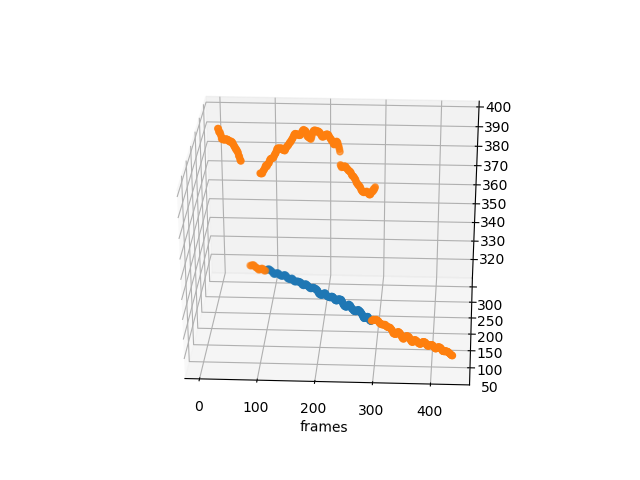

In [18]:
%matplotlib notebook
showTubes([1,5])

H: [4, 2, 7]
L: [1, 3, 5, 6, 8]
BYE [0]
0.7656574268514571


<IPython.core.display.Javascript object>


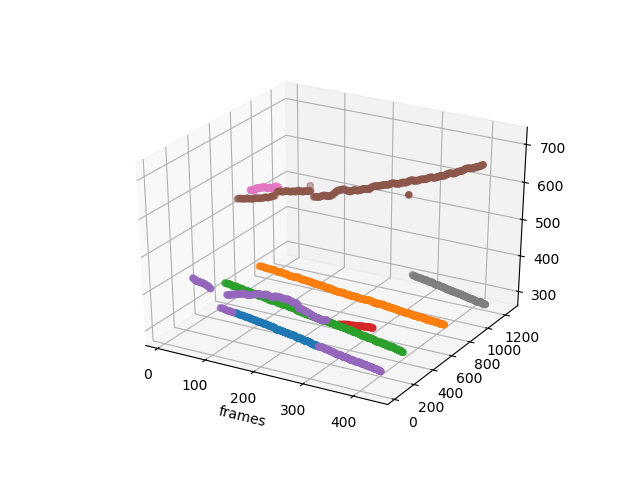

<IPython.core.display.Javascript object>


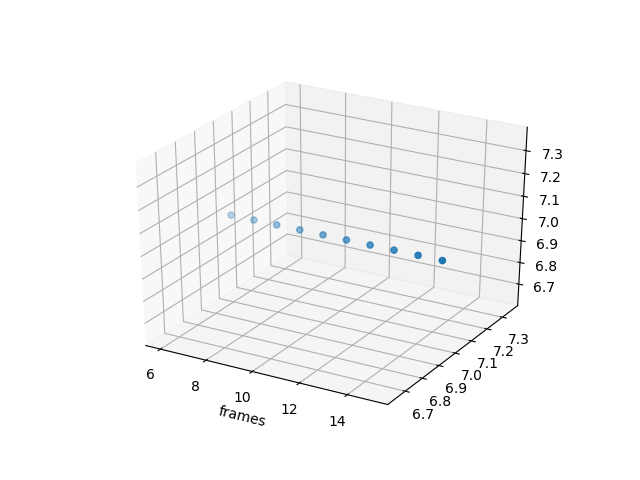

<IPython.core.display.Javascript object>


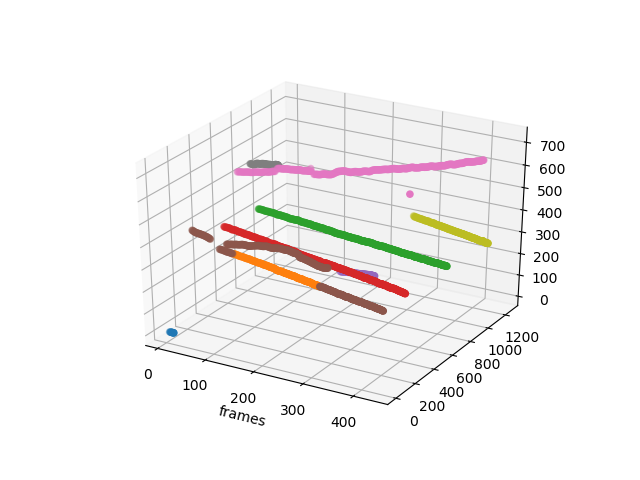

In [117]:
#DO SOMETHING TO ADD TUBENUMS TO JUMPYLIST (FOR DELETION)
#A: SPLIT INTO THREE(FIVE?) GROUPS AND TAKE MOST JUMPY
#B: CHECK AVG AND TAKE ANYTHING ABOVE 2 ST DEVS AWAY
#C: 


jumpyList = []

# Populate jumpiness array
J = np.zeros(numTubes)
for t in range(numTubes):
    J[t] = tubeStats[t][1]

'''
#METHOD A. Take the most jumpy 5th and delete them
tubeStats.sort(key = lambda x: x[1])  
k = round(numTubes *0.2)
print(tubeStats)
for i in range(k):
    jumpyList.append(tubeStats[-(i+1)][0])  
print()
print(jumpyList)


#-----------------------------------------------------------------
#METHOD B. Delete > 2 st. devs away from mean jumpiness
J = np.zeros(numTubes)
for t in range(numTubes):
    J[t] = tubeStats[t][1]
cutoff = 2*np.std(J) + np.mean(J)
print(J)
print("IQR=", scipy.stats.iqr(J))
print("Mean=", np.mean(J))


jumpyList = [tup[0] for tup in tubeStats if tup[1] > cutoff]
'''
#-----------------------------------------------------------------
#METHOD C. Above the median-> high tier. <2 seconds -> del
highList = []
lowList = []
tubeStats.sort(key = lambda x: x[1]) 
cutoff = tubeStats[-round(numTubes *0.2)][1]

highList.extend([tup[0] for tup in tubeStats if ((tup[1]<np.median(J)) and (tup[2]>60)) ])
jumpyList.extend([tup[0] for tup in tubeStats if  ((tup[1]> cutoff) and (tup[1]>10)) ])
jumpyList.extend([tup[0] for tup in tubeStats if (tup[2]<60) ])
lowList.extend(t for t in range(numTubes) if t not in jumpyList and t not in highList)

splitcheck =[]
#GO THRU JL AND MOVE ANY "DECENT" TUBES TO LL
for j in jumpyList:
    jtube = getTube(DATA,j)
    jstats = [stat for stat in tubeStats if stat[0] == j].pop(0)
    
    if jstats[2] > 60: #If more than 2 seconds long...
        
        split = round(jstats[2]/3)
        splitJF = []
        
        print("Tube:",j)
        
        deltaD=0
        i=0
        #Calculate "jumpiness"
        while(i+1 < split):
            deltaD += math.sqrt((jtube[i+1,0] - jtube[i,0])**2 + (jtube[i+1,1] - jtube[i,1])**2 )
            i+=1
        splitJF.append(deltaD/split)
        deltaD=0
        while(i+1 < 2*split):
            deltaD += math.sqrt((jtube[i+1,0] - jtube[i,0])**2 + (jtube[i+1,1] - jtube[i,1])**2 )
            i+=1
        splitJF.append(deltaD/split)
        deltaD=0
        while(i+1 < jstats[2]):
            deltaD += math.sqrt((jtube[i+1,0] - jtube[i,0])**2 + (jtube[i+1,1] - jtube[i,1])**2 )
            i+=1
        splitJF.append(deltaD/split)
        
        print(splitJF)
        if any(s < np.mean(J)/2 for s in splitJF):
            splitcheck.append((j,np.argmin(splitJF)+1))
            jumpyList.remove(j)
            lowList.append(j)
            print(j, "makes it in")

#lowList.extend([tup[0] for tup in tubeStats if ((tup[0] not in highList) and (tup[2]>60)) ])
#jumpyList.extend(t for t in range(numTubes) if t not in lowList and t not in highList)

SC = dict(splitcheck)
print("H:", highList)
print("L:", lowList)
print("BYE", jumpyList)
print(np.median(J))

%matplotlib notebook
notjumpyList = highList +lowList

showTubes(notjumpyList)
showTubes(jumpyList)
showTubes()



In [118]:
#"C:\\Users\\f002tj9\\Documents\\Research\\kj\\Tubes\\TubeFile2020\\virat4_tubelistv0.csv"

outCSV = "C:\\Users\\f002tj9\\Documents\\Research\\kj\\Tubes\\TubeFile2020\\virat4_tubelistv8.csv"

saveTubesCSV(outCSV,notjumpyList)

<IPython.core.display.Javascript object>


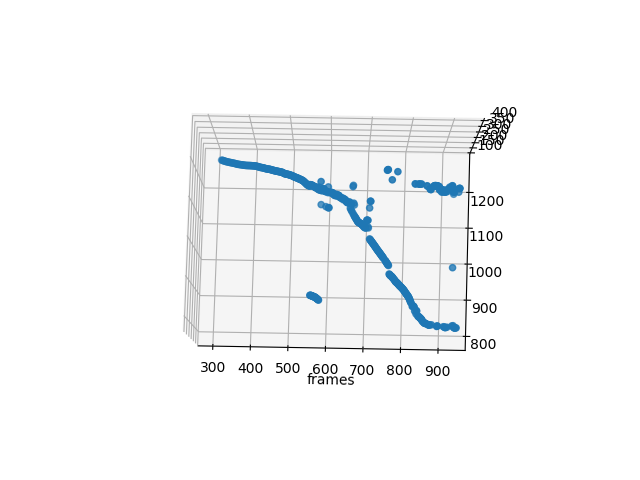

In [88]:
showTubes([26])

In [95]:
Tmat = []
for t in notjumpyList:
    if t not in SC:
        Tmat.extend(getTube(DATA,t))
    else:
        T = getTube(DATA,t)
        split = round(T.shape[0]/3)
        check = SC[t]
        Tmat.extend(T[(check-1)*split : check*split])

        
print(Tmat)

[array([ 8.70192277e+02,  2.80367268e+02,  2.81147912e+01,  1.90199444e+01,
       -1.48397929e+00,  2.08000000e+02,  5.28789079e-02,  7.03223803e-01,
        4.91416278e-01,  1.86296728e-01,  1.64455163e-01,  2.30000000e+01]), array([ 8.69453794e+02,  2.81838176e+02,  2.81623980e+01,  1.91957269e+01,
       -7.12585480e-01,  2.09000000e+02,  5.76275126e-02,  7.06018996e-01,
        4.91416278e-01,  1.86296728e-01,  1.64455163e-01,  2.30000000e+01]), array([ 8.69051257e+02,  2.82506990e+02,  2.88186408e+01,  1.93999501e+01,
       -7.23640561e-01,  2.10000000e+02,  4.30738230e-02,  6.97899488e-01,
        4.91416278e-01,  1.86296728e-01,  1.64455163e-01,  2.30000000e+01]), array([ 8.69520383e+02,  2.81971456e+02,  2.88186408e+01,  1.96965862e+01,
       -7.12585480e-01,  2.11000000e+02,  4.33479140e-02,  6.85481620e-01,
        4.91416278e-01,  1.86296728e-01,  1.64455163e-01,  2.30000000e+01]), array([ 8.69254065e+02,  2.82345978e+02,  2.89550385e+01,  1.96965862e+01,
       -7.220238

In [101]:
#showTubes([2])
tubeStats[-round(numTubes *0.2)][1]

33.11342943842045

In [97]:
print(c)

3
